In [1]:
# import packages
import pandas as pd 
import folium
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import requests
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

%matplotlib inline

In [2]:
# open the csv file with geospatial data of colombo district
geospatialData = pd.read_csv('colomboCensusProcessed.csv')
geospatialData.head()

,DS,GN,GN Number,Both sexes,Male,Female,Latitude,Longitude
0,Colombo,Sammanthranapura,NaN,7829,4017,3812,6.978943,79.877983
1,Colombo,Mattakkuliya,NaN,28003,14029,13974,6.971672,79.878683
2,Colombo,Modara,NaN,17757,8794,8963,6.966925,79.871153
3,Colombo,Madampitiya,NaN,12970,6505,6465,6.961663,79.875184
4,Colombo,Mahawatta,NaN,8809,4367,4442,6.958307,79.873084


In [3]:
# drop the unwanted columns
geospatialData.drop(['GN Number', 'Both sexes', 'Male', 'Female'], axis=1, inplace=True)

In [4]:
# location of colombo
colomboLocation = [6.926523627315386, 79.85483152436545]

In [5]:
# add a column to the df to store the distance from colombo
geospatialData['Distance from Colombo'] = None
# add distance data to df
for latitude, longitude, index in zip(geospatialData['Latitude'], geospatialData['Longitude'], geospatialData.index):
    distanceColombo = geodesic([latitude, longitude], colomboLocation).km
    geospatialData.at[index, 'Distance from Colombo'] = distanceColombo
geospatialData.head()

,DS,GN,Latitude,Longitude,Distance from Colombo
0,Colombo,Sammanthranapura,6.978943,79.877983,6.336563
1,Colombo,Mattakkuliya,6.971672,79.878683,5.646016
2,Colombo,Modara,6.966925,79.871153,4.818306
3,Colombo,Madampitiya,6.961663,79.875184,4.489975
4,Colombo,Mahawatta,6.958307,79.873084,4.052534


In [6]:
# locations more than 15km away from Colombo cann't consider as good locations to construct apartment buildings due to traffic conditions
# drop the locations more than 15km away from the city
geospatialData = geospatialData[(geospatialData['Distance from Colombo']<15)]
# locations closer than 5km is dropped, because the land prices are sky high
geospatialData = geospatialData[(geospatialData['Distance from Colombo']>5)]
geospatialData.head()

,DS,GN,Latitude,Longitude,Distance from Colombo
0,Colombo,Sammanthranapura,6.978943,79.877983,6.336563
1,Colombo,Mattakkuliya,6.971672,79.878683,5.646016
40,Kolonnawa,Halmulla,6.953490,79.895480,5.391848
46,Kolonnawa,Kittampahuwa,6.943663,79.900379,5.378471
48,Kolonnawa,Maha Buthgamuwa B,6.945843,79.909475,6.405504


In [7]:
# visualize the selected locations
# create a map object
colomboMap = folium.Map(location=colomboLocation, zoom_start=11)
# add markers of GN locations to map
for latitude, longitude, label in zip(geospatialData['Latitude'], geospatialData['Longitude'], geospatialData['GN']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=True
        ).add_to(colomboMap)
# visuallize the base location in red color
folium.CircleMarker(
    colomboLocation,
    radius=2,
    color='red',
    fill=True,
    fill_color='red',
    fill_opacity=0.7,
    parse_html=True
    ).add_to(colomboMap)
# visualize the map
colomboMap

In [58]:
# get the venues near the selected locations using Foursqure API
# Foursqure credentials
CLIENT_ID = 'VU2AEMY2CCFAIDMYNX4GGHA1IISEQ5KHVOQH3OWEEW5VUK2U' # Foursquare ID
CLIENT_SECRET = '0BEY2YJ2OF1CWXVC1Z23QKN10YWGCV0CQ4DQBGL3OVEOMJ3Q' # Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [59]:
# define a list to store the venues
venues = []
# looping through the df to get the nerby venue details
for latitude, longitude, gn in zip(geospatialData['Latitude'], geospatialData['Longitude'], geospatialData['GN']):
    # request url
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            latitude, 
            longitude, 
            2000, # only concider 2,000m radius around the selected location due to reachability.
            LIMIT)
    # create a get request
    results = requests.get(url).json()['response']['groups'][0]['items']
    # append venue details to the list
    venues.append([(
        gn,
        latitude,
        longitude,
        venue['venue']['name'],
        venue['venue']['location']['lat'],
        venue['venue']['location']['lng'],
        venue['venue']['categories'][0]['name']) for venue in results])

In [60]:
# convert the list to df
nearbyVenues = pd.DataFrame([item for venue in venues for item in venue])
# add column names to df
nearbyVenues.columns = ['GN',
                        'GN Latitude',
                        'GN Longitude',
                        'Venue',
                        'Venue Latitude',
                        'Venue Longitude',
                        'Venue Category']
nearbyVenues.head()

,GN,GN Latitude,GN Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Sammanthranapura,6.978943,79.877983,Pegasus Reef Hotel,6.982707,79.884876,Hotel Bar
1,Sammanthranapura,6.978943,79.877983,Odel,6.987292,79.890251,Clothing Store
2,Sammanthranapura,6.978943,79.877983,Crow Island Beach,6.973375,79.869410,Beach
3,Sammanthranapura,6.978943,79.877983,Fashion Bug,6.987690,79.890495,Clothing Store
4,Sammanthranapura,6.978943,79.877983,Pizza Hut,6.986227,79.889353,Pizza Place


In [61]:
# one hot encoding
colomboVenues = pd.get_dummies(nearbyVenues[['Venue Category']], prefix="", prefix_sep="")
# add GN column to the df
colomboVenues['GN'] = nearbyVenues['GN']
# rearranging the columns
columnNames = ['GN']+[columnName for columnName in list(colomboVenues.columns) if columnName != 'GN']
colomboVenues = colomboVenues[columnNames]
colomboVenues.head()

,GN,Accessories Store,Airport,Airport Terminal,Aquarium,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Toll Booth,Track,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Warehouse Store,Women's Store,Zoo
0,Sammanthranapura,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Sammanthranapura,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Sammanthranapura,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Sammanthranapura,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Sammanthranapura,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [103]:
# extracting column names of the df
columnNames = list(colomboVenues.columns)

In [105]:
# there are lot of restaurant types in this df
# sum up those restaurant columns to one column
# copy the colomboVenues df to a temp df, so I can apply my functions
temp = colomboVenues.copy()
# list the column names with restaurant
restaurants = []
for venue in columnNames:
    if 'restaurant' in venue.lower():
        restaurants.append(venue)
# sum up all restaurants into a single cloumn
temp['Restaurants'] = temp.loc[:, restaurants].sum(axis=1)
# drop the columns in restaurant list
temp.drop(restaurants, axis=1, inplace=True)
# assign the temp df to colomboVenues df
colomboVenues = temp.copy()

In [106]:
# group the venues 
colomboGroupedVenues = colomboVenues.groupby('GN').mean()
colomboGroupedVenues.reset_index(inplace=True)
colomboGroupedVenues.head()

,GN,Accessories Store,Airport,Airport Terminal,Aquarium,Arcade,Art Gallery,Arts & Crafts Store,Athletics & Sports,Auto Garage,...,Theme Park,Toll Booth,Track,Trail,Train Station,Video Store,Warehouse Store,Women's Store,Zoo,Restaurants
0,Ambathale,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000,0.0,0.0,0.0,0.000000
1,Angulana North,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.150000,0.000,0.0,0.0,0.0,0.100000
2,Angulana South,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037037,0.0,...,0.000000,0.0,0.0,0.000000,0.074074,0.000,0.0,0.0,0.0,0.185185
3,Arangala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.125,0.0,0.0,0.0,0.250000
4,Aruppitiya,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.025641,0.0,0.0,0.025641,0.000000,0.000,0.0,0.0,0.0,0.333333


In [107]:
# removing labels from df
colomboClusteringVenues = colomboGroupedVenues.drop('GN', axis=1)

In [129]:
# elbow method is used to get the optimum number of clusters
nClusters = [i for i in range(1, 15)]
sumofSquaredError = []

for nCluster in nClusters:
    kMeans = KMeans(nCluster, random_state=0).fit(colomboClusteringVenues)
    sumofSquaredError.append(kMeans.inertia_)

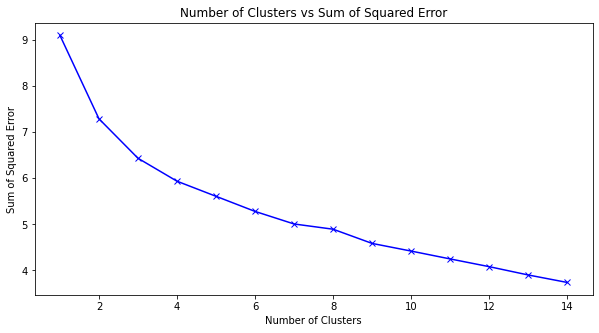

In [130]:
# plot the sum of squared error against cluster number
plt.figure(figsize=(10, 5))
plt.plot(nClusters, sumofSquaredError, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Error')
plt.title('Number of Clusters vs Sum of Squared Error')
plt.show()

In [131]:
# based on above figure, select number of clusters as 3
k = 2
# redo the clustering for the selected number of clusters
kMeans = KMeans(k, random_state=0).fit(colomboClusteringVenues)

In [132]:
# identify the common properties of each cluster
# adding cluster labels to df
colomboClustered = colomboGroupedVenues.copy()
colomboClustered.insert(1, 'Cluster Labels', kMeans.labels_)
# Merge the df with geospatialData df
colomboClustered = geospatialData.join(colomboClustered.set_index('GN'), on='GN')
colomboClustered.reset_index(inplace=True, drop=True)
colomboClustered.head()

,DS,GN,Latitude,Longitude,Distance from Colombo,Cluster Labels,Accessories Store,Airport,Airport Terminal,Aquarium,...,Theme Park,Toll Booth,Track,Trail,Train Station,Video Store,Warehouse Store,Women's Store,Zoo,Restaurants
0,Colombo,Sammanthranapura,6.978943,79.877983,6.336563,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.217391
1,Colombo,Mattakkuliya,6.971672,79.878683,5.646016,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.187500
2,Kolonnawa,Halmulla,6.953490,79.895480,5.391848,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.071429,0.0,0.0,0.0,0.0,0.214286
3,Kolonnawa,Kittampahuwa,6.943663,79.900379,5.378471,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.076923
4,Kolonnawa,Maha Buthgamuwa B,6.945843,79.909475,6.405504,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.142857


In [133]:
# group the rows based on cluster labels
groupedCluster = colomboClustered.drop(['DS', 'GN', 'Latitude', 'Longitude', 'Distance from Colombo'], axis=1)
groupedCluster = groupedCluster.groupby('Cluster Labels').mean()
groupedCluster.reset_index(inplace=True)
groupedCluster.head()

,Cluster Labels,Accessories Store,Airport,Airport Terminal,Aquarium,Arcade,Art Gallery,Arts & Crafts Store,Athletics & Sports,Auto Garage,...,Theme Park,Toll Booth,Track,Trail,Train Station,Video Store,Warehouse Store,Women's Store,Zoo,Restaurants
0,0,0.000000,0.004963,0.007090,0.026703,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.005376,0.000000,0.000000,0.002304,0.000000,0.000000,0.006272,0.000000,0.103814
1,1,0.000305,0.003955,0.002381,0.000000,0.001303,0.00019,0.000698,0.008672,0.002499,...,0.001778,0.000518,0.007334,0.003807,0.014551,0.004769,0.001084,0.005120,0.000837,0.223714


In [134]:
# define a function to get most common venues
def getCommonVenues(row, venueCount):
    categories = row.iloc[1:]
    sortedCategories = categories.sort_values(ascending=False)
    return sortedCategories.index[0:venueCount]

In [135]:
# creating df with most common properties of each cluster
# number of common venues
venueCount = 10
indicators = ['st', 'nd', 'rd']
# create a list of column names
columnNames = ['Cluster Labels']
for i in range(venueCount):
    if i<len(indicators):
        columnNames.append('{}{} Most Common Venue'.format(i+1, indicators[i]))
    else:
        columnNames.append('{}th Most Common Venue'.format(i+1))
# create a df with new column names
clusterProperties = pd.DataFrame(columns=columnNames)
clusterProperties['Cluster Labels'] = groupedCluster['Cluster Labels']
# filling other columns of the df
for i in range(groupedCluster.shape[0]):
    clusterProperties.iloc[i, 1:] = getCommonVenues(groupedCluster.iloc[i, :], venueCount)
clusterProperties

,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Bus Station,Restaurants,Supermarket,Grocery Store,Department Store,Pizza Place,Convenience Store,Bakery,Clothing Store,Aquarium
1,1,Restaurants,Supermarket,Bakery,Convenience Store,Pizza Place,Clothing Store,Gym,Shopping Mall,Bus Station,Diner
